In [1]:
class Node:
    def __init__(self, id, radius=None, total_time=None, level=0,end_point=None):
        self.id = id
        self.radius = radius
        self.total_time = total_time
        self.level = level
        self.children = []
        self.visit_count = 0
        self.end_point = end_point
        self.value = 0.0  # For MCTS
        self.parent = None  # For MCTS

    def add_child(self, node):
        """Adds a child to the current node."""
        node.level = self.level + 1
        node.parent = self  # Set parent for MCTS
        self.children.append(node)
        
    def delete_child(self, node):
        """Removes a child from the current node."""
        if node in self.children:
            self.children.remove(node)

    def display(self):
        """Displays the current node's information."""
        print(f"Node ID: {self.id}, Radius: {self.radius}, Total Time: {self.total_time}")

    def traverse(self):
        """Traverses and displays the tree starting from the current node."""
        self.display()
        for child in self.children:
            child.traverse()

    def get_nodes(self):
        """Returns all nodes in the tree starting from the current node."""
        nodes = [self]
        for child in self.children:
            nodes.extend(child.get_nodes())
        return nodes

    def ucb1(self, exploration_constant=1.41):
        """Calculates the UCB1 value for MCTS."""
        if self.visit_count == 0:
            return float('inf')
        parent_visits = self.parent.visit_count if self.parent is not None else 1
        return self.value / self.visit_count + exploration_constant * math.sqrt(
            math.log(parent_visits) / self.visit_count)

    def best_child(self):
        """Returns the best child based on UCB1 values."""
        return min(self.children, key=lambda node: node.ucb1(), default=None)

    def fully_expanded(self):
        """Checks if the node is fully expanded."""
        return len(self.radius) == len(waypoints) - 1  # -1 since the sequence length is one less than waypoints

    def update(self, reward):
        """Updates the node's value and visit count based on the given reward."""
        self.visit_count += 1
        self.value += reward




In [2]:
import numpy as np
from Common_function import *
import matplotlib.pyplot as plt
from itertools import product
import itertools

x = 2  #how are is the distance set
Total_E_UGV = 500000
Total_E_UAV = 15000
UAV_E_cost = 1250

UGV_E_cost_with_UAV = 1000
UGV_E_cost_without_UAV = 800
Charging_speed = 1000
speed_uav =30
speed_ugv =10
ten_minets = 2
survey_time = ten_minets/6
UAV_E_s_cost = 2500*ten_minets
print(UAV_E_s_cost)
# waypoints = [(20, 10), (24, 37), (36, 43), (8, 8), (0, 50), (30, 44), (28, 4), (32, 25)]
waypoints = [(20,10), (10,10),(15,30)]
plan_output = "0 -> 1 -> 2 -> 0"
# plan_output = "0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 7 -> 6 -> 0"
max_radius = ((Total_E_UAV - UAV_E_s_cost) / UAV_E_cost) / 2
radii = np.linspace(1.0, max_radius, x)
ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
ordered_points.append(ordered_points[0])


5000


In [3]:
import numpy as np

# I am assuming the functions like angle_between_points, point_on_circle, find_meeting_point_with_survey_final, etc. 
# are previously defined. However, as they are not provided here, I'll make the necessary modifications based on the code provided.

def compute_optimized_paths_for_radius_updated_v5(ordered_points, radius, speed_ugv, speed_uav, survey_time):
    UGV_outer_path = []
    UGV_path = [ordered_points[0]]
    UAV_path = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone = []
    chord_end = None
    prev_chord_end = None
    
    radius_set = []
    
    for i, point in enumerate(ordered_points[:-1]):
        # Replace current_radius with radius
        if 0 < i < len(ordered_points) - 2:
            # assuming angle_between_points and point_on_circle functions are defined previously
            angle = angle_between_points(ordered_points[i-1], ordered_points[i])
            nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
            chord_start = point_on_circle(ordered_points[i], angle - np.pi, radius)
            chord_end = point_on_circle(ordered_points[i], nextangle, radius)
            radius_set.append(radius)
            
            if prev_chord_end and i > 1 and circles_overlap(ordered_points[i], radius, ordered_points[i-1], radius):
                chord_start = prev_chord_end

            # assuming find_meeting_point_with_survey_final function is defined previously
            final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
                ordered_points[i], radius, chord_start, chord_end, 
                speed_ugv, speed_uav, survey_time
            )
     
            
            if chord_start:
                UAV_path_segment = [chord_start, point, final_meeting_point]
                UAV_path.append(UAV_path_segment)
                UGV_path.append(chord_start)
                # assuming calculate_UAV_inter_distances_inter function is defined previously
                UAV_path_segment_distance = calculate_UAV_inter_distances_inter(UAV_path_segment)
                if i == 1:
                    UGV_outer_path.append([ordered_points[0], chord_start])
                else:
                    UGV_outer_path.append([prev_chord_end, chord_start])
                    
            if chord_end:
                UGV_path.append(chord_end)
            # assuming compute_distance function is defined previously
            inter_distance_without_drone = compute_distance(chord_start, final_meeting_point)
            inter_distance_with_drone = compute_distance(final_meeting_point, chord_end)
            UGVD_inter_without_drone.append(inter_distance_without_drone)
            UGVD_inter_with_drone.append(inter_distance_with_drone)
            prev_chord_end = chord_end
            end_point = chord_end
    UGV_path.append(ordered_points[-1])
    UGV_outer_path.append([chord_end,ordered_points[-1]])
    
    return radius_set, UGV_path, UAV_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time, end_point



In [47]:
def compute_path_for_one_point(ordered_points, point_index, radius, speed_ugv, speed_uav, survey_time):
    if point_index <= 0 or point_index >= len(ordered_points) - 1:
        raise ValueError("Invalid point index. It should be between 1 and len(ordered_points) - 2.")
    
    UGV_outer_path = []
    UGV_path = []
    UAV_path = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone = [] 0
    
    if point_index > 1 and circles_overlap(ordered_points[point_index], radius, ordered_points[point_index - 1], radius):
        chord_start = prev_chord_end

    # Assuming find_meeting_point_with_survey_final function is defined previously
    final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
        ordered_points[point_index], radius, chord_start, chord_end, 
        speed_ugv, speed_uav, survey_time
    )
    # final_wait_set.append(final_wait_time)
    
    if chord_start:
        UAV_path_segment = [chord_start, point, final_meeting_point]
        UAV_path.append(UAV_path_segment)
        UGV_path.append(chord_start)
        
        # Assuming calculate_UAV_inter_distances_inter function is defined previously
        UAV_path_segment_distance = calculate_UAV_inter_distances_inter(UAV_path_segment)
        if point_index == 1:
            UGV_outer_path.append([ordered_points[0], chord_start])
        else:
            UGV_outer_path.append([prev_chord_end, chord_start])
                    
    if chord_end:
        UGV_path.append(chord_end)
    end_point = chord_end
    # Assuming compute_distance function is defined previously
    inter_distance_without_drone = compute_distance(chord_start, final_meeting_point)
    inter_distance_with_drone = compute_distance(final_meeting_point, chord_end)
    UGVD_inter_without_drone.append(inter_distance_without_drone)
    UGVD_inter_with_drone.append(inter_distance_with_drone)
    
    return radius, UGV_path, UAV_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time,end_point



In [4]:
def calculate_UAV_inter_distances_inter(UAV_path):
    UAV_inter_distances = 0
    group_distance=0
    for i in range(len(UAV_path) - 1):
        group_distance += compute_distance(UAV_path[i], UAV_path[i + 1])
    UAV_inter_distances=group_distance
    return UAV_inter_distances

In [105]:
def tsp_output_to_tree(tsp_output, waypoints, radii):
    nodes_in_order = tsp_output.split()
    nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]
    
    # Create root node (start)
    root = Node(id=0, radius=None, total_time=0)
    
    # Global counter for node ID
    node_counter = [1]  # Using a list so it's mutable inside nested functions

    def add_node(parent, waypoint_index):
        if waypoint_index >= len(nodes_in_order):
            return

        for r in radii:
            
            radius, UGV_path, UAV_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time,chord_end = compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)
            UGV_outer_path_section = []
            
            # UGVD_inter_without_drone 
            if waypoint_index == 1:
                UGV_outer_path_section.append([ordered_points[0], UAV_path[0][0]])
                UGV_distance = compute_distance(UGV_path[0],UGV_path[1]) +compute_distance(UAV_path[0][0],UAV_path[0][-1])
                total_time = parent.total_time + final_wait_time + UGV_distance / speed_ugv
            else:
                UGV_outer_path_section.append([parent.end_point ,UAV_path[0][-1]])
                print(compute_distance(parent.end_point,UAV_path[0][0]))
                UGV_distance = compute_distance(UGV_path[0],UGV_path[1]) +compute_distance(UAV_path[0][0],UAV_path[0][-1]) +compute_distance(parent.end_point,UAV_path[0][0])
                total_time = parent.total_time + final_wait_time + UGV_distance / speed_ugv
            
            child = Node(id=node_counter[0], radius=r, total_time=total_time)
            parent.add_child(child)
            child.end_point = UAV_path[0][-1]
            node_counter[0] += 1  # Increment global node ID counter
            add_node(child, waypoint_index + 1)
            print(f"id:{child.id}, R:{r}, UGV_path :{UGV_path},UGV_distance:{UGV_distance}")
    add_node(root, 1)

    return root



In [102]:

def calculate_energy_remaining_inter(Total_E_UGV, Total_E_UAV, UGV_outer_path_distances, UGVD_inter_with_drone, UAV_distances_set, UAV_path, UAV_E_cost, UAV_E_s_cost, UGVD_inter_without_drone, UGV_E_cost_without_UAV, Charging_speed):
    UGV_energy_remaining = Total_E_UGV
    UAV_energy_remaining = Total_E_UAV

    for i in range(len(UGV_outer_path_distances)-1):
        charging_distance = UGVD_inter_with_drone[i] + UGV_outer_path_distances[i+1]
        UAV_distances = UAV_distances_set[i]
        
        UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost * (len(UAV_path[i])-2)
        UGV_Trip_Cost = UGVD_inter_without_drone[i] * UGV_E_cost_without_UAV
        
        UAV_energy_remaining -= UAV_Trip_Cost 
        UGV_energy_remaining -= UGV_Trip_Cost
        
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , UAV_Trip_Cost, UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
        
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            return -1, -1  # Indicating mission failed for both

    return UGV_energy_remaining, UAV_energy_remaining

In [88]:

# waypoints = [(20, 10), (24, 37), (36, 43)]
NUM_WAYPOINTS = len(waypoints)
# plan_output = "0 -> 1 -> 2 -> 0 "
# radii = [2,5]
TIME_BETWEEN_NODES = 1
MAX_TIME_LIMIT = 20

In [103]:
root = tsp_output_to_tree(plan_output, waypoints, radii)

18.6155281280883
18.6155281280883
id:3, R:1.0, UGV_path :[(19.757464374963668, 10.970142500145332), (21.0, 10.0)],UGV_distance:20.191939004120517
15.615528128088302
id:4, R:4.0, UGV_path :[(19.029857499854668, 13.880570000581328), (24.0, 10.0)],UGV_distance:21.921171632217174
id:2, R:1.0, UGV_path :[(14.757464374963668, 29.029857499854668), (15.242535625036332, 29.029857499854668)],UGV_distance:19.100599378160965
15.615528128088302
15.6155281280883
id:6, R:1.0, UGV_path :[(19.757464374963668, 10.970142500145332), (21.0, 10.0)],UGV_distance:17.191939004120517
12.6155281280883
id:7, R:4.0, UGV_path :[(19.029857499854668, 13.880570000581328), (24.0, 10.0)],UGV_distance:18.921171632217174
id:5, R:4.0, UGV_path :[(14.02985749985467, 26.11942999941867), (15.970142500145332, 26.11942999941867)],UGV_distance:17.555813128378965
id:1, R:1.0, UGV_path :[(11.0, 10.0), (10.242535625036332, 10.970142500145332)],UGV_distance:2.4616488376105443
15.734709896566295
18.6155281280883
id:10, R:1.0, UGV_pat

In [99]:
root.traverse()

Node ID: 0, Radius: None, Total Time: 0
Node ID: 1, Radius: 1.0, Total Time: 0.5230824418805271
Node ID: 2, Radius: 1.0, Total Time: 2.8331423796966235
Node ID: 3, Radius: 1.0, Total Time: 5.2523362801086755
Node ID: 4, Radius: 4.0, Total Time: 5.532900630521564
Node ID: 5, Radius: 4.0, Total Time: 2.8786637547184237
Node ID: 6, Radius: 1.0, Total Time: 4.997857655130476
Node ID: 7, Radius: 4.0, Total Time: 5.278422005543363
Node ID: 8, Radius: 4.0, Total Time: 0.9654122094026356
Node ID: 9, Radius: 1.0, Total Time: 2.9873903240665314
Node ID: 10, Radius: 1.0, Total Time: 5.406584224478583
Node ID: 11, Radius: 4.0, Total Time: 5.687148574891471
Node ID: 12, Radius: 4.0, Total Time: 3.0329289284925647
Node ID: 13, Radius: 1.0, Total Time: 5.152122828904616
Node ID: 14, Radius: 4.0, Total Time: 5.4326871793175044


18.6155281280883
18.6155281280883
id:3, R:1.0, UGV_path :[(19.757464374963668, 10.970142500145332), (21.0, 10.0)],UGV_distance:20.191939004120517
15.615528128088302
id:4, R:4.0, UGV_path :[(19.029857499854668, 13.880570000581328), (24.0, 10.0)],UGV_distance:21.921171632217174
id:2, R:1.0, UGV_path :[(14.757464374963668, 29.029857499854668), (15.242535625036332, 29.029857499854668)],UGV_distance:19.100599378160965
15.615528128088302
15.6155281280883
id:6, R:1.0, UGV_path :[(19.757464374963668, 10.970142500145332), (21.0, 10.0)],UGV_distance:17.191939004120517
12.6155281280883
id:7, R:4.0, UGV_path :[(19.029857499854668, 13.880570000581328), (24.0, 10.0)],UGV_distance:18.921171632217174
id:5, R:4.0, UGV_path :[(14.02985749985467, 26.11942999941867), (15.970142500145332, 26.11942999941867)],UGV_distance:17.555813128378965
id:1, R:1.0, UGV_path :[(11.0, 10.0), (10.242535625036332, 10.970142500145332)],UGV_distance:2.4616488376105443
15.734709896566295
18.6155281280883
id:10, R:1.0, UGV_pat

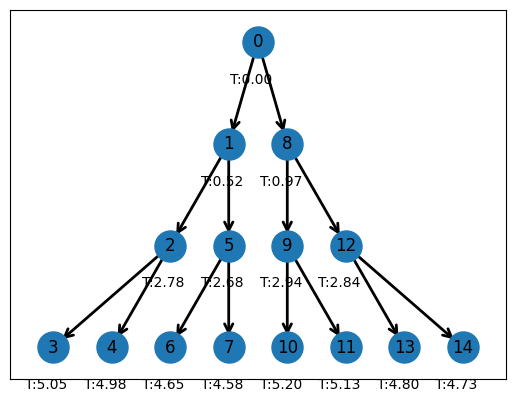

In [104]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
def draw_tree(root):
    def add_edges(graph, node):
        for child in node.children:
            graph.add_edge(node.id, child.id)
            add_edges(graph, child)

    G = nx.DiGraph()
    add_edges(G, root)

    # Get all nodes and sort by level
    all_nodes = sorted(root.get_nodes(), key=lambda node: node.level)

    # Count nodes per level
    level_counts = defaultdict(int)

    # Assign positions
    pos = {}
    for node in all_nodes:
        pos[node.id] = (level_counts[node.level], -node.level)
        level_counts[node.level] += 1

    # Adjust x-positions to center nodes on each level
    for node in all_nodes:
        x_adjust = -0.5 * (level_counts[node.level] - 1)
        pos[node.id] = (pos[node.id][0] + x_adjust, pos[node.id][1])

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)

    # Edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, width=2)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Node data annotations
    for node in all_nodes:
        plt.annotate(
            f'T:{node.total_time:.2f}',
            xy=pos[node.id], textcoords='offset points', xytext=(-20,-30))

    plt.show()

# Generating the tree
root_node = tsp_output_to_tree(plan_output, waypoints, radii)

# Drawing the tree
draw_tree(root_node)
